<a href="https://colab.research.google.com/github/FereolKpavode/CHURN/blob/main/customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [230]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


![](https://i.ibb.co/yQ3D64X/face.jpg)

## Customer churn



**Il est nécessaire de prédire si le client quittera la banque dans un avenir proche ou non.
Nous disposons de données historiques sur le comportement des clients et la résiliation de contrats avec la banque**


## Présentation générale des données opérationnelles et analyse exploratoire préliminaire

### Chargement des modules nécessaires à l’entraînement et à l’évaluation des modèles

In [231]:
!pip install catboost > /dev/null 2>&1
!pip install catboost > /dev/null 2>&1
!pip install catboost > /dev/null 2>&1
!pip install catboost > /dev/null 2>&1

In [232]:

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import Pool, cv
from sklearn.utils import shuffle
import joblib
import math
import warnings
warnings.filterwarnings("ignore")

### Exploration du jeu de données

In [233]:
df = pd.read_csv('/content/drive/MyDrive/MEMOIRE/Customer-Churn-Records.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Features:

| **Nom brut**         | **Nom retravaillé                                   | **Description potentielle**         |
| -------------------- | --------------------------------------------------- | ----------------------------------- |
| `RowNumber`          | Numéro de ligne                                     | A ignorer                           |
| `CustomerId`         | Identifiant client                                  | A ignorer                           |
| `Surname`            | Nom de famille                                      | A ignorer                           |
| `CreditScore`        | **Score de crédit**                                 | Niveau de solvabilité               |
| `Geography`          | **Pays ou région**                                  | Localisation géographique           |
| `Gender`             | **Sexe**                                            | Homme/Femme                         |
| `Age`                | **Âge**                                             |                                     |
| `Tenure`             | **Ancienneté du client** (en années)                | Durée de la relation avec la banque |
| `Balance`            | **Solde du compte**                                 | Solde moyen ou actuel               |
| `NumOfProducts`      | **Nombre de produits bancaires**                    | Ex : compte, carte, prêt            |
| `HasCrCard`          | **Détention de carte de crédit** (1 = oui, 0 = non) | OK                                  |
| `IsActiveMember`     | **Client actif**                                    | Activité perçue par la banque       |
| `EstimatedSalary`    | **Salaire estimé / Revenu mensuel estimé**          | EN EURO                             |
| `Complain`           | **Réclamation enregistrée**                         | 1 = oui, 0 = non                    |
| `Satisfaction Score` | **Score de satisfaction client**                    | Échelle à préciser                  |
| `Card Type`          | **Type de carte bancaire**                          | Ex : Gold, Silver, etc.             |
| `Point Earned`       | **Points fidélité accumulés**                       | OK                                  |

Target :
| `Exited`             | **Attrition** (1 = a quitté la banque)              | Cible                               |



Pour plus de commodité, nous mettrons les noms des colonnes en minuscules

In [234]:
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'complain',
       'satisfaction score', 'card type', 'point earned'],
      dtype='object')

df.columns = ['row_number', 'customer_id', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'isactive_member', 'estimated_salary', 'exited']
df.columns

Examinons les informations générales relatives aux données utilisées

In [235]:
print(df.shape)
df.info()

(10000, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rownumber           10000 non-null  int64  
 1   customerid          10000 non-null  int64  
 2   surname             10000 non-null  object 
 3   creditscore         10000 non-null  int64  
 4   geography           10000 non-null  object 
 5   gender              10000 non-null  object 
 6   age                 10000 non-null  int64  
 7   tenure              10000 non-null  int64  
 8   balance             10000 non-null  float64
 9   numofproducts       10000 non-null  int64  
 10  hascrcard           10000 non-null  int64  
 11  isactivemember      10000 non-null  int64  
 12  estimatedsalary     10000 non-null  float64
 13  exited              10000 non-null  int64  
 14  complain            10000 non-null  int64  
 15  satisfaction score  10000 non-null  int64 

Nous n’avons aucune valeur manquante (NaN) dans notre jeu de données


Analysons individuellement les types de données présents dans notre DataFrame afin de mieux comprendre la nature de chaque variable.

In [236]:
df.dtypes

,0
rownumber,int64
customerid,int64
surname,object
creditscore,int64
geography,object
gender,object
age,int64
tenure,int64
balance,float64
numofproducts,int64


we need `tenure` to be integre

In [237]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rownumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
customerid,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
creditscore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
numofproducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
hascrcard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
isactivemember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimatedsalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


# Vérification de la présence de variables aberrantes dans notre jeu de données

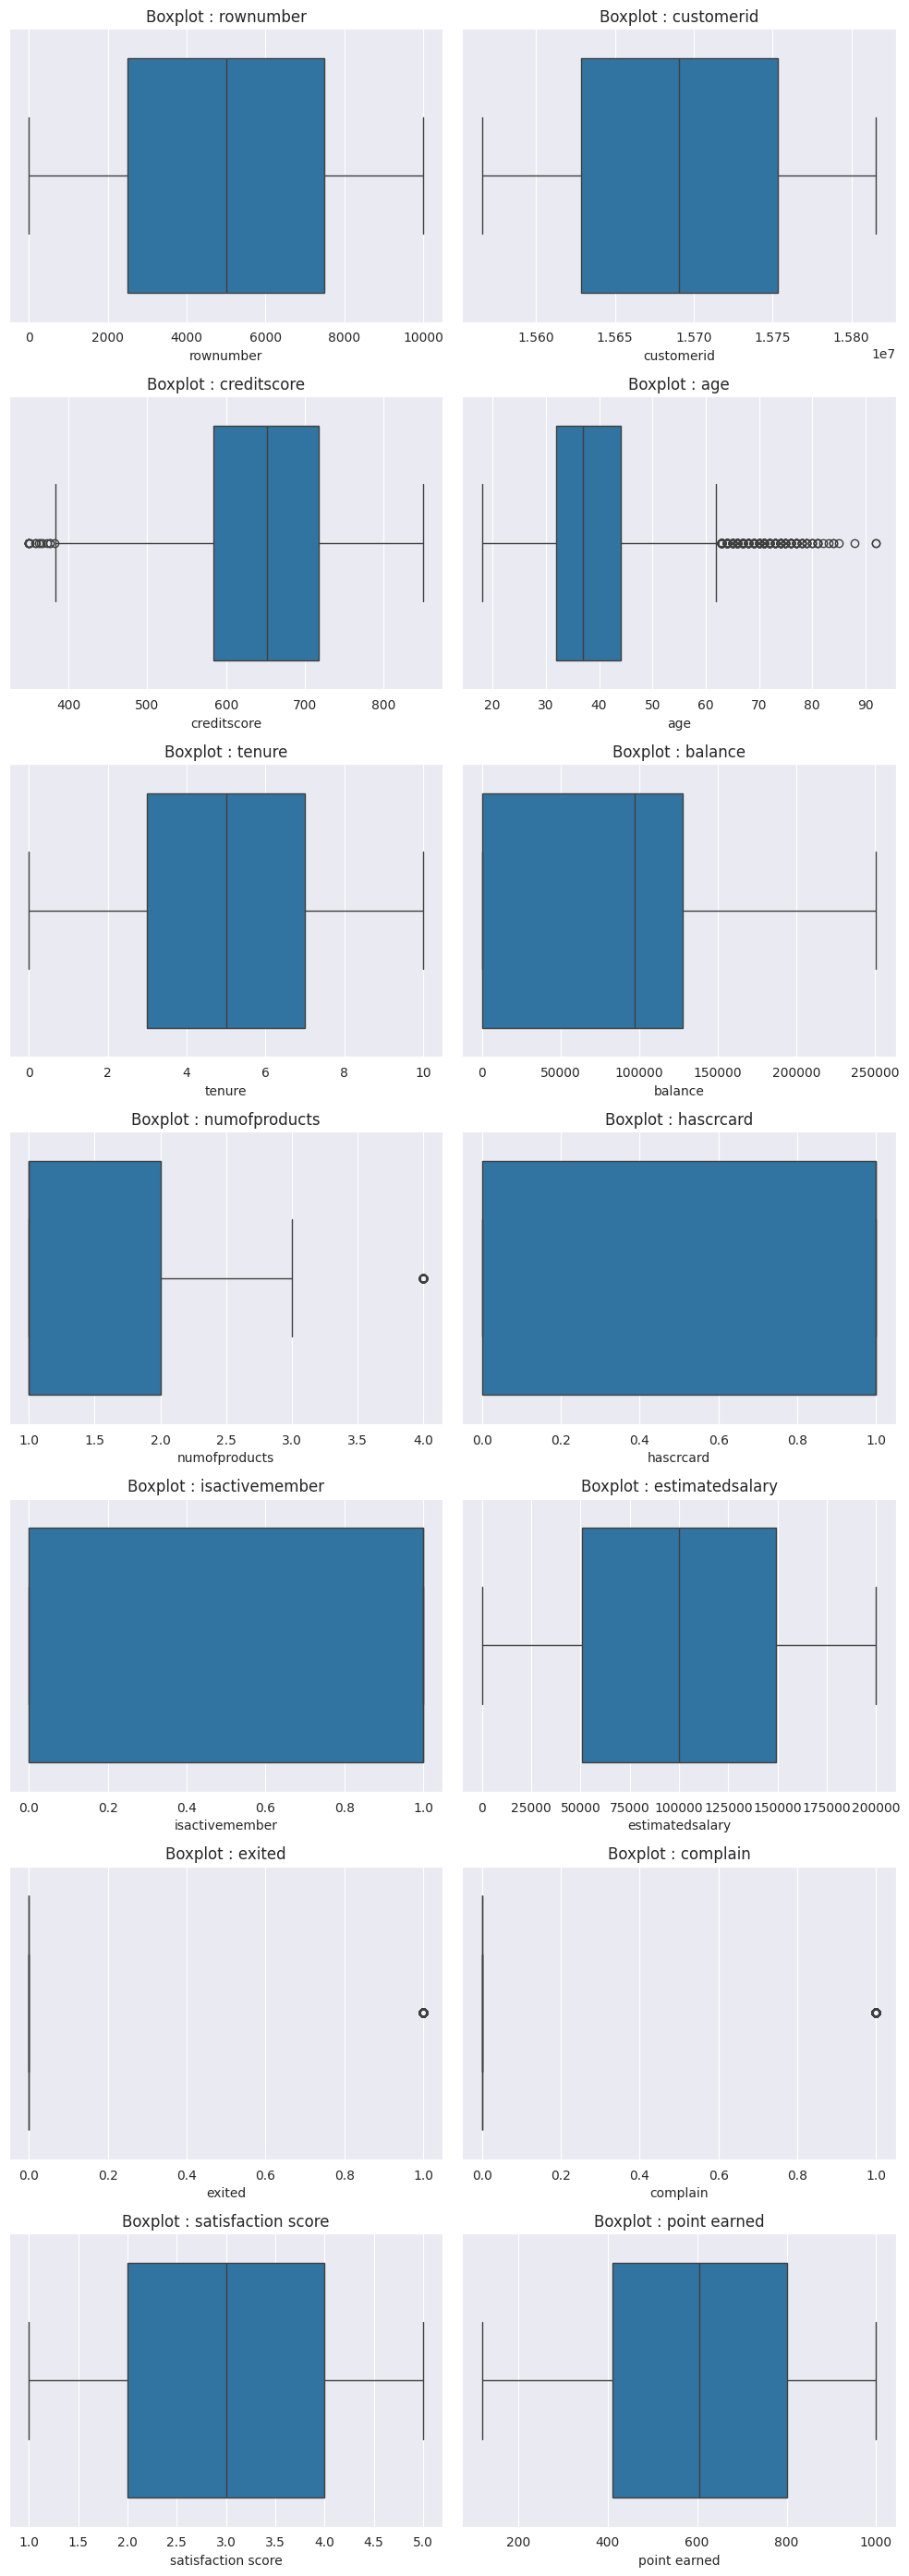

In [238]:
# Sélection des colonnes numériques
colonnes_numeriques = df.select_dtypes(include='number').columns
nb_colonnes = len(colonnes_numeriques)

# Définir le nombre de graphiques par ligne
plots_par_ligne = 2

# Calcul du nombre de lignes nécessaires
nb_lignes = math.ceil(nb_colonnes / plots_par_ligne)

# Création de la grille de subplots
fig, axes = plt.subplots(nb_lignes, plots_par_ligne, figsize=(plots_par_ligne*5, nb_lignes*4))

# Aplatir les axes (au cas où) pour itérer facilement
axes = axes.flatten()

# Boucle pour tracer chaque boxplot
for i, col in enumerate(colonnes_numeriques):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot : {col}')

# Masquer les axes inutilisés (si colonnes < nb de subplots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster les espacements
plt.tight_layout()
plt.show()

A la lecture des boxplots :
 - La variable creditscore présente quelques valeurs atypiques, légèrement éloignées de la distribution principale. Cette variabilité est cohérente avec la diversité des profils clients, dont les niveaux de risque de solvabilité peuvent différer en fonction de plusieurs facteurs, tels que la situation financière, l’historique de crédit ou encore le comportement bancaire. Une telle hétérogénéité est attendue dans le cadre d'une analyse de l’attrition, car elle reflète les différences individuelles susceptibles d’influencer la fidélité ou la résiliation d’un contrat bancaire.

 - La variable Age présente quelques observations relativement éloignées de la majorité des valeurs, notamment des clients âgés. Toutefois, cette dispersion reste cohérente, étant donné que l’âge des clients observés varie entre 18 et 92 ans. Il s’agit d’une plage plausible qui reflète la diversité démographique de la clientèle bancaire. Ainsi, aucune correction ou transformation ne sera appliquée à cette variable.

Vérifions s'il y a de cohérence entre les variables qualitatives

In [239]:
qualitatives = df.select_dtypes(include='object').columns

for col in qualitatives:
    print(f"Modalités et fréquences de la variable '{col}':")
    print(df[col].value_counts(dropna=False))
    print('-'*40)

Modalités et fréquences de la variable 'surname':
surname
Smith        32
Scott        29
Martin       29
Walker       28
Brown        26
             ..
Wells         1
Calzada       1
Gresswell     1
Aguirre       1
Morales       1
Name: count, Length: 2932, dtype: int64
----------------------------------------
Modalités et fréquences de la variable 'geography':
geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
----------------------------------------
Modalités et fréquences de la variable 'gender':
gender
Male      5457
Female    4543
Name: count, dtype: int64
----------------------------------------
Modalités et fréquences de la variable 'card type':
card type
DIAMOND     2507
GOLD        2502
SILVER      2496
PLATINUM    2495
Name: count, dtype: int64
----------------------------------------


L’analyse des variables qualitatives n’a mis en évidence aucune anomalie ou valeur incohérente justifiant une intervention ou un nettoyage spécifique avant l’étape de modélisation.

Passons maintenant à l'analyse de la variable expliquée.

In [240]:
df['exited'].value_counts().to_frame()

,count
exited,
0,7962
1,2038


In [241]:
print("Taux d'attrition des clients : {:.2%}".format(df['exited'].mean()))

Taux d'attrition des clients : 20.38%


Il y a un déséquilibre de classes. Nous allons d'abord entraîner le modèle sur les données initiales, puis nous essaierons de corriger ce déséquilibre et nous entraînerons à nouveau le modèle. Nous analyserons ensuite les résultats.

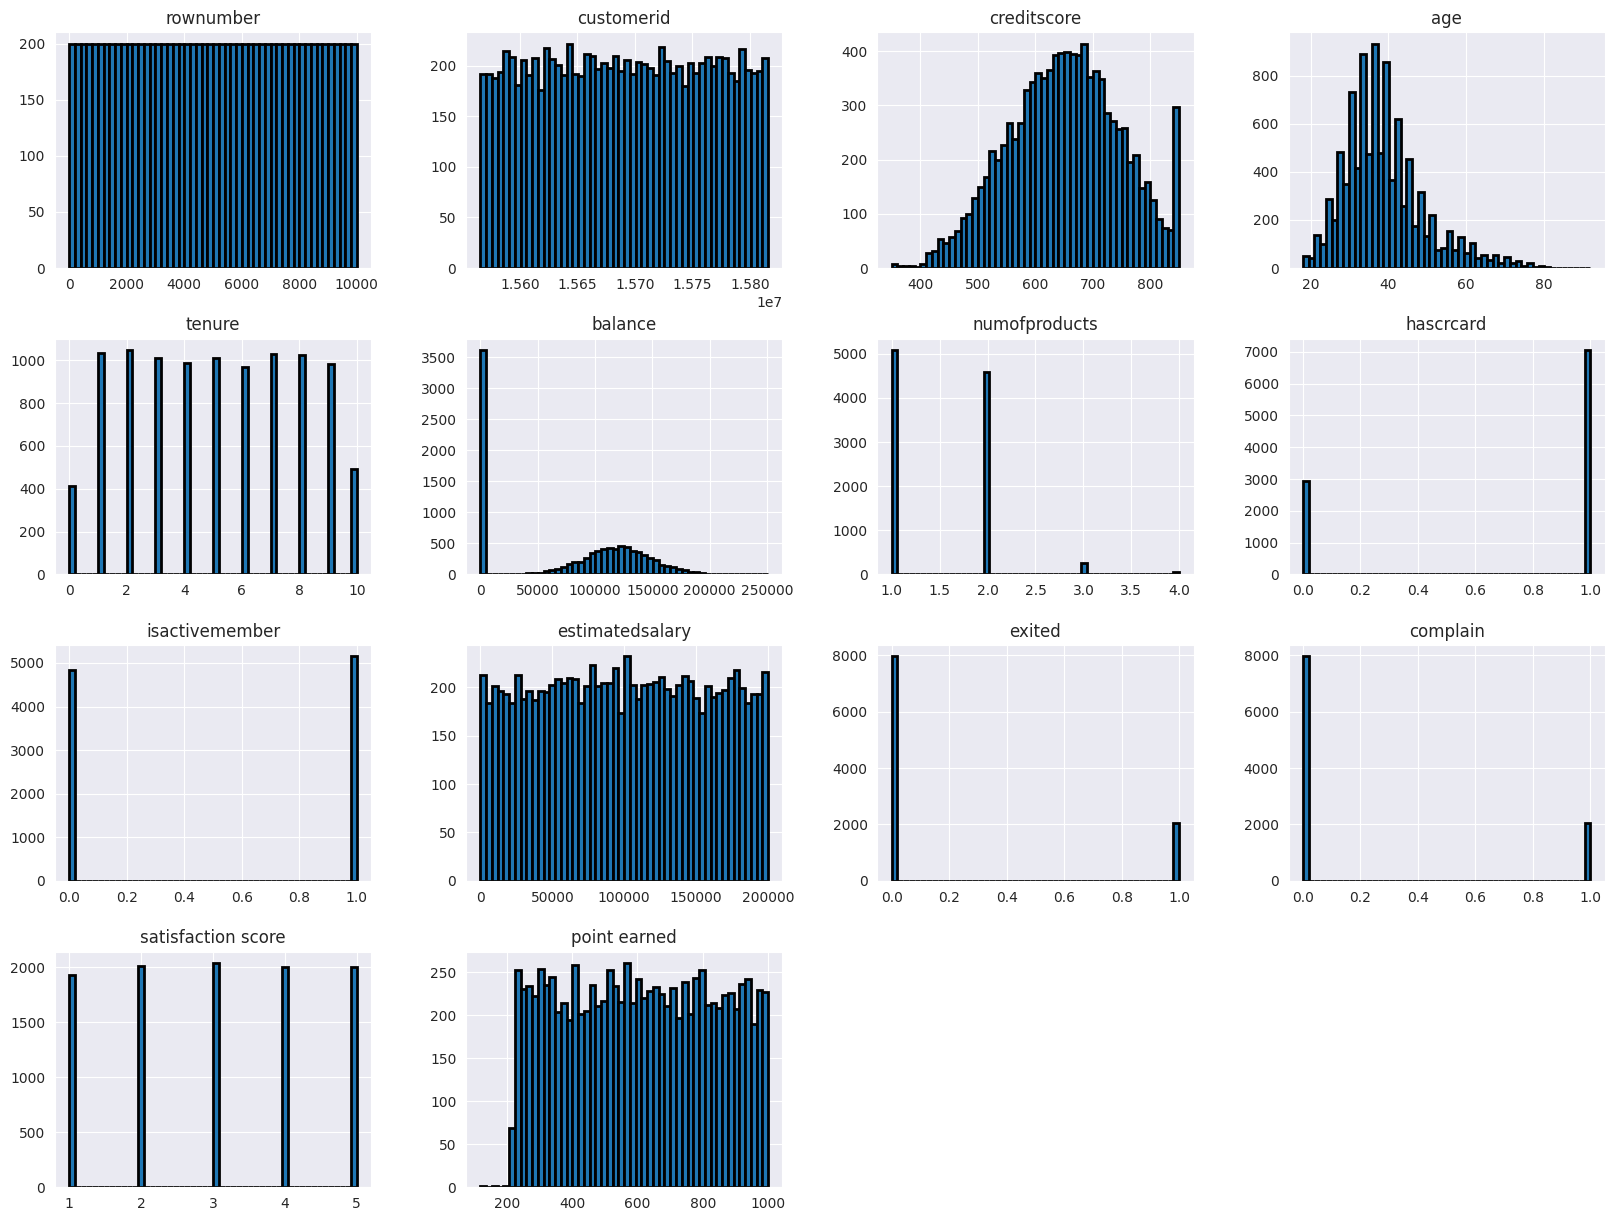

In [242]:
df.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2)
plt.show()

Lors de la phase de construction des variables explicatives, nous avons identifié les colonnes 'customerid', 'rownumber' et 'surname' comme non informatives ; elles seront donc exclues de l'entraînement du modèle.

In [243]:
df.duplicated().sum()

np.int64(0)

### Conclusion

##Comprendre l'attrition client : un enjeu stratégique
L'attrition client (ou customer churn) représente bien plus qu'une simple métrique : c'est le reflet de la capacité d'une entreprise à fidéliser sa clientèle. Ce phénomène se manifeste par l'interruption des paiements ou l'abandon des achats sur une période donnée, constituant ainsi un indicateur critique pour toute organisation, particulièrement celles évoluant dans l'écosystème des modèles d'abonnement ou de revenus récurrents.

##État des lieux : un jeu de données prêt à révéler ses secrets
Notre exploration initiale du dataset a révélé une situation plutôt favorable pour l'analyse à venir. La qualité des données s'avère remarquable : aucune duplication n'a été identifiée, nous épargnant ainsi la fastidieuse étape de nettoyage qui accompagne souvent ce type d'investigation.
Dans une démarche d'optimisation de notre pipeline analytique, nous avons procédé à un élagage stratégique des variables non pertinentes. Les colonnes customerid, rownumber et surname ont été écartées de notre analyse, ces identifiants n'apportant aucune valeur prédictive à notre modélisation future.

##Cap vers la modélisation : préparer le terrain
Fort de cette base de données épurée, nous voici désormais en mesure d'entamer la phase cruciale de feature engineering. Cette étape, véritable pierre angulaire de notre approche, nous permettra de façonner les variables explicatives pour optimiser les performances de notre modèle prédictif d'attrition client.

## Research of task

##Objectif de la modélisation et choix des algorithmes
Nous sommes confrontés à une problématique de classification binaire : il s’agit de déterminer si un client risque de quitter la banque dans un avenir proche ou non.
Pour répondre à cet objectif, nous proposons d’utiliser plusieurs algorithmes d’apprentissage supervisé, notamment :

la régression logistique,

le Random Forest,

et le CatBoost, particulièrement performant sur des données tabulaires hétérogènes.


| Modèle              | Rôle dans le mémoire        | Avantages                                           |
| ------------------- | --------------------------- | --------------------------------------------------- |
| Logistic Regression | Baseline / interprétabilité | Simple, bonne compréhension des facteurs            |
| Random Forest       | Modèle de référence robuste | Importance des variables, peu de tuning             |
| CatBoost            | Modèle final performant     | Gère le déséquilibre et les variables catégorielles |





### **Choix des métriques d’évaluation**

Étant donné que notre jeu de données présente un **déséquilibre de classes**, la **précision globale (accuracy)** n’est pas une métrique fiable dans ce contexte. Nous privilégierons donc :

* **la mesure F1 (F1-score)** pour l’évaluation des modèles intermédiaires, car elle prend en compte à la fois la précision (*precision*) et le rappel (*recall*).

  > Une valeur **supérieure à 0.60** sera considérée comme acceptable.

* **la courbe ROC et l’aire sous la courbe (AUC-ROC)** pour évaluer les performances globales du **modèle final**. Cette métrique est particulièrement adaptée aux problèmes de classification avec classes déséquilibrées.


### Features engeneering

In [244]:
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction score,card type,point earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Éliminons les variables inutiles et créons un nouveau dataset pour éviter d'écraser les variables existantes

In [245]:
data = df.drop(['rownumber', 'customerid', 'surname'], axis=1).copy()
data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction score,card type,point earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


### One-hot Encoding

Les caractéristiques catégorielles `geography`,`gender` et `card type` doivent être transformées en variables numériques à l'aide de la technique d'encodage direct, également appelée encodage one-hot (One-Hot Encoding, OHE). Cette conversion en variables quantitatives est nécessaire pour améliorer la précision de notre modèle.

In [246]:
data['geography'].value_counts()

,count
geography,
France,5014
Germany,2509
Spain,2477


In [247]:
data['gender'].value_counts()

,count
gender,
Male,5457
Female,4543


In [248]:
data['card type'].value_counts()

,count
card type,
DIAMOND,2507
GOLD,2502
SILVER,2496
PLATINUM,2495


In [249]:
# Encodage One-Hot des variables catégorielles
gender_ohe = pd.get_dummies(df["gender"], drop_first=True)
country_ohe = pd.get_dummies(df["geography"], drop_first=True)
cardtype_ohe = pd.get_dummies(df["card type"], drop_first=True)

# Suppression des variables catégorielles d’origine
data.drop(["gender", "geography","card type"], axis=1, inplace=True)

# Concatenation des nouvelles colonnes encodées au DataFrame principal
df_ohe = pd.concat([data, gender_ohe, country_ohe,cardtype_ohe], axis=1)

df_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction score,point earned,Male,Germany,Spain,GOLD,PLATINUM,SILVER
0,619,42,2,0.00,1,1,1,101348.88,1,1,2,464,False,False,False,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,1,3,456,False,False,True,False,False,False
2,502,42,8,159660.80,3,1,0,113931.57,1,1,3,377,False,False,False,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,0,5,350,False,False,False,True,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,0,5,425,False,False,True,True,False,False


In [250]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   creditscore         10000 non-null  int64  
 1   age                 10000 non-null  int64  
 2   tenure              10000 non-null  int64  
 3   balance             10000 non-null  float64
 4   numofproducts       10000 non-null  int64  
 5   hascrcard           10000 non-null  int64  
 6   isactivemember      10000 non-null  int64  
 7   estimatedsalary     10000 non-null  float64
 8   exited              10000 non-null  int64  
 9   complain            10000 non-null  int64  
 10  satisfaction score  10000 non-null  int64  
 11  point earned        10000 non-null  int64  
 12  Male                10000 non-null  bool   
 13  Germany             10000 non-null  bool   
 14  Spain               10000 non-null  bool   
 15  GOLD                10000 non-null  bool   
 16  PLATI

Les colonnes ont été encodées.

Il est également nécessaire de standardiser les caractéristiques, car les valeurs quantitatives varient fortement.
Cependant, nous n’appliquerons pas la standardisation aux colonnes `tenure`, `num_of_products`, `has_crcard`, `isactive_member` ainsi qu’à la variable cible qui est une variable catégorielle transformée.



### Séparation du jeu de données

> Nous avons préparé les variables explicatives. Maintenant, nous allons diviser nos échantillons en un ensemble d'entraînement, un ensemble de validation pour le choix des hyperparamètres, et un ensemble de test sur lequel nous évaluerons notre modèle.
> Nous ne toucherons pas à l’échantillon de test avant la fin ; nous utiliserons cet ensemble pour évaluer la meilleure version du modèle.


In [251]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [252]:
features, target = split_data(df_ohe,'exited')

Une portion de 20 % des données est dédiée à la validation, tandis que les 80 % restantes sont à nouveau partagées pour isoler un échantillon de test. Ainsi, l’apprentissage du modèle se fera sur 60 % des données.


In [253]:
features_df, features_valid, target_df, target_valid = (
                                train_test_split(
                                features, target, test_size=0.20, random_state=42)
)


In [254]:
features_train, features_test, target_train, target_test = (
                                train_test_split(
                                features_df, target_df, test_size=0.25, random_state=42)
)


In [255]:
print('Taille du jeu d''entraiment:', len(features_train))
print('Taille du jeu de validation:', len(features_valid))
print('Taille du jeu de test :', len(features_test))
print('Somme des jeux d''entrainement, de test et de valaidation :', len(features_train) + len(features_test) + len(features_test))
print()
print('Taille de la data set initiale :', len(df_ohe))

Taille du jeu dentraiment: 6000
Taille du jeu de validation: 2000
Taille du jeu de test : 2000
Somme des jeux dentrainement, de test et de valaidation : 10000

Taille de la data set initiale : 10000


L’échantillon a été divisé, nous pouvons maintenant procéder à un premier entraînement des modèles.
Dans cette étude, les classes sont fortement déséquilibrées, ce qui nuit à la qualité de l’entraînement.
Observons les résultats : nous évaluerons le modèle avec la mesure F1 — une métrique adaptée pour apprécier la performance d’un classifieur.
La mesure F1 combine en un seul indicateur deux métriques essentielles : la **précision** (`precision`) et le **rappel** (`recall`).

### Normalisation ( Mise à l'échelle )

La mise à l’échelle des variables sur l’ensemble du jeu de données peut entraîner une fuite de données (*data leak*).
Il faut **entraîner le scaler uniquement sur le jeu d’entraînement**.

Nous allons donc d’abord entraîner le scaler, puis l’appliquer à nos différents échantillons.


In [256]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary', 'point earned']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,complain,satisfaction score,point earned,Male,Germany,Spain,GOLD,PLATINUM,SILVER
8588,0.626553,-0.948125,7,0.026803,1,1,0,0.389943,0,3,1.658505,False,False,True,False,False,True
3178,-1.143262,0.006684,4,0.538874,2,1,1,-1.026089,0,4,-1.201937,False,False,False,False,False,True
5200,-1.455583,0.293126,9,0.283178,2,1,0,-1.486725,0,5,-0.131492,True,True,False,False,True,False
8889,-0.747657,0.006684,9,0.833254,1,1,0,-0.246001,0,1,-0.682260,False,False,False,True,False,False
5789,0.387107,1.534377,1,0.000856,1,1,0,-1.006993,1,3,1.325379,False,True,False,True,False,False


Nous allons appliquer le scaler préalablement entraîné au jeu de validation.

In [257]:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,complain,satisfaction score,point earned,Male,Germany,Spain,GOLD,PLATINUM,SILVER
6252,-0.581086,-0.661682,3,0.327195,2,0,0,-1.017034,0,1,0.441484,True,True,False,True,False,False
4684,-0.299998,0.388607,1,-1.218934,2,1,1,0.805136,0,2,-0.451293,True,False,False,False,False,True
1731,-0.529032,0.484088,4,-1.218934,2,1,0,-0.724818,0,1,-1.459554,False,False,True,True,False,False
4742,-1.518047,1.916301,8,0.686002,2,1,1,1.228495,0,2,1.640738,True,True,False,False,False,True
4521,-0.955870,-1.139087,7,0.779430,1,1,1,0.252697,0,5,-0.677819,False,False,True,False,False,True


Nous allons appliquer le scaler préalablement entraîné au jeu de test.

In [258]:
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,complain,satisfaction score,point earned,Male,Germany,Spain,GOLD,PLATINUM,SILVER
3188,1.553103,-0.661682,4,-0.017150,1,1,1,-1.084803,0,1,-0.704469,False,False,False,False,False,True
8293,1.188729,-1.043606,4,0.231074,1,0,1,-1.368802,0,1,-0.047100,False,True,False,False,True,False
1710,1.834191,-1.043606,8,0.935642,1,1,0,-0.362538,0,3,0.570293,True,False,True,True,False,False
7510,1.521871,-0.279759,1,-1.218934,2,1,1,1.025781,0,4,-0.024892,True,False,False,True,False,False
1461,-0.424926,-0.470721,4,-1.218934,2,1,0,1.233214,0,4,1.338704,True,False,True,False,False,False


### Phase d’entraînement exploratoire des modèles, sans correction du déséquilibre entre les classes.

####Régression logistique

Commençons par une régression logistique simple, sans tenir compte des poids des classes

In [259]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.9974554707379135



Bien que le F1 soit élévé, entrainons le modèle en tenant compte du déséquilibre des classes

In [260]:
model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.9974554707379135


##Interprétation :
Le modèle est déjà très performant, même sans ajustement des poids.
Cela signifie probablement que :

Le déséquilibre entre les classes n’est pas très sévère, ou

Le modèle parvient déjà à bien prédire la classe minoritaire.

L’ajout de class_weight='balanced' n’a pas dégradé la performance, ce qui est une bonne chose.
Cela confirme que le modèle est robuste.

##  Matrice de confusion

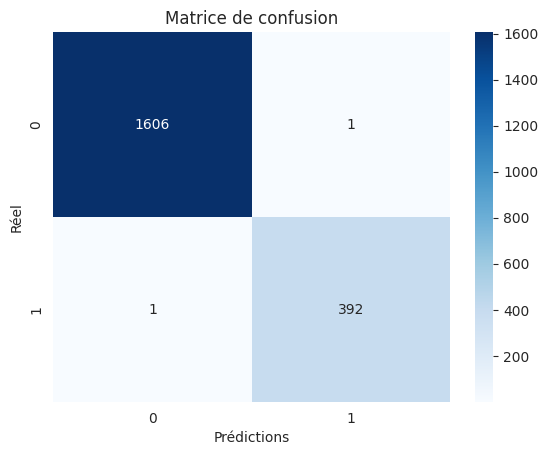

In [261]:
cm = confusion_matrix(target_valid, predicted_valid)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

Passons maontenant à l'algoithme du Random forest

#### Random forest

In [262]:
model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.9961783439490446


In [263]:
model = RandomForestClassifier(random_state=42, n_estimators=10, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.9974554707379135


Bien que l’indicateur de performance du modèle Random Forest ait été satisfaisant même sans correction du déséquilibre des classes, nous avons tout de même appliqué une méthode de rééquilibrage. Cette démarche a permis une légère amélioration de l’indicateur, lequel atteint désormais un niveau équivalent à celui obtenu avec la régression logistique.

#### Catboost

In [264]:
model = CatBoostClassifier(verbose=100, random_state=42)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

Learning rate set to 0.022141
0:	learn: 0.6265215	total: 3.38ms	remaining: 3.38s
100:	learn: 0.0046138	total: 407ms	remaining: 3.62s
200:	learn: 0.0018822	total: 1.04s	remaining: 4.14s
300:	learn: 0.0010924	total: 2.19s	remaining: 5.08s
400:	learn: 0.0007291	total: 3.37s	remaining: 5.03s
500:	learn: 0.0006210	total: 4.75s	remaining: 4.73s
600:	learn: 0.0006041	total: 5.4s	remaining: 3.58s
700:	learn: 0.0006040	total: 6.18s	remaining: 2.64s
800:	learn: 0.0006039	total: 6.9s	remaining: 1.71s
900:	learn: 0.0006039	total: 7.83s	remaining: 860ms
999:	learn: 0.0006039	total: 8.83s	remaining: 0us
F1: 0.9974554707379135


L’entraînement du modèle CatBoost s’est effectué sur 1 000 itérations, avec un taux d’apprentissage automatiquement ajusté à 0,022. La fonction de perte est passée de 0,626 à 0,0006, témoignant d’un excellent ajustement du modèle aux données d’apprentissage. À l’évaluation sur l’échantillon de validation, le F1-score atteint 0,997, ce qui indique des performances quasi parfaites dans la détection de l’attrition, même en présence d’un déséquilibre important des classes.

La F1 est une mesure relativement élevée, examinons les résultats après avoir sélectionné les hyperparamètres et testé le modèle sur un échantillon de test.

### Conclusion


Nous abordons un problème de classification. Pour améliorer la qualité des prévisions et faciliter l’apprentissage du modèle, nous avons procédé à plusieurs transformations des données :

* Élimination des variables non pertinentes, telles que le nom de famille, l’identifiant du client et le numéro de ligne
* Encodage des variables qualitatives
* Normalisation des variables numériques
* Répartition des données en trois sous-ensembles selon le ratio 60 % / 20 % / 20 % :

  * un jeu d’entraînement,
  * un jeu de validation pour ajuster les hyperparamètres et vérifier le modèle,
  * un jeu de test pour l’évaluation finale.

Nous avons d'abord entraîné les modèles sur des données déséquilibrées en termes de classes. À présent, nous allons chercher à corriger ce déséquilibre et procéder au réglage des hyperparamètres du modèle.


## Correction des déséquilibres et perfectionnement des modèles d’apprentissage

Il existe un déséquilibre dans la répartition des classes dans notre jeu de données, analysons cela plus en détail

In [265]:
df['exited'].value_counts().to_frame()

,count
exited,
0,7962
1,2038


Nous allons tenter trois méthodes pour résoudre ce problème, puis retenir celle qui offre les meilleurs résultats pour optimiser notre modèle.

### Sur-échantillonnage

Pour cela, utilisons une fonction qui applique les transformations suivantes :

* Séparer l’échantillon d’apprentissage en deux groupes : les objets négatifs et les objets positifs
* Dupliquer plusieurs fois les objets positifs
* À partir des données obtenues, créer un **nouvel échantillon d’apprentissage équilibré**
* Mélanger les données aléatoirement pour éviter tout biais d’ordre


In [266]:
def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled



features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

print(features_upsampled.shape)
print(target_upsampled.shape)

(10924, 17)
(10924,)


#### Logistic regression

In [267]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.9974554707379135


La performance du modèle est restée stable, que l’on corrige ou non le déséquilibre des classes.

#### Random Forest

In [268]:
model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.9974554707379135


La performance observée est équivalente à celle obtenue en utilisant l’option `class_weight`.

#### Catboost

In [269]:
model = CatBoostClassifier(verbose=100, random_state=42)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

Learning rate set to 0.028597
0:	learn: 0.6033666	total: 28.4ms	remaining: 28.4s
100:	learn: 0.0031053	total: 1.37s	remaining: 12.2s
200:	learn: 0.0013772	total: 2.49s	remaining: 9.91s
300:	learn: 0.0008521	total: 3.53s	remaining: 8.19s
400:	learn: 0.0008011	total: 4.29s	remaining: 6.41s
500:	learn: 0.0007921	total: 5.06s	remaining: 5.04s
600:	learn: 0.0007892	total: 6.63s	remaining: 4.4s
700:	learn: 0.0007888	total: 8.9s	remaining: 3.79s
800:	learn: 0.0007877	total: 10.2s	remaining: 2.54s
900:	learn: 0.0007873	total: 11.4s	remaining: 1.25s
999:	learn: 0.0007870	total: 12.4s	remaining: 0us
F1: 0.9974554707379135


La performance mesurée est comparable à celle obtenue précédemment.

Essayons une autre approche : réduire la taille de l’échantillon.

### Sous-échantillonnage (Downsampling)

Pour cela, utilisons une fonction qui réalise les opérations suivantes :

* Séparer l’échantillon d’entraînement en objets négatifs et positifs
* Supprimer aléatoirement une partie des objets négatifs
* À partir des données ainsi obtenues, créer un nouvel échantillon d’entraînement équilibré
* Mélanger les données de manière aléatoire afin d’éviter tout biais lié à l’ordre


In [270]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=0.1, random_state=12345)
    target_sample = target_zeros.sample(frac=0.1, random_state=12345)

    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])

    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)



    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

print(features_downsampled.shape)
print(target_downsampled.shape)

(1708, 17)
(1708,)



#### Logistic regression

In [271]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.9974554707379135


#### Random forest

In [272]:
model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.9974554707379135


#### Catboost

In [273]:
model = CatBoostClassifier(verbose=100, random_state=42)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))



Learning rate set to 0.012948
0:	learn: 0.6623041	total: 6.31ms	remaining: 6.3s
100:	learn: 0.0209169	total: 456ms	remaining: 4.06s
200:	learn: 0.0067923	total: 1.17s	remaining: 4.63s
300:	learn: 0.0032515	total: 1.77s	remaining: 4.12s
400:	learn: 0.0019101	total: 2s	remaining: 2.99s
500:	learn: 0.0013425	total: 2.21s	remaining: 2.2s
600:	learn: 0.0011840	total: 2.42s	remaining: 1.6s
700:	learn: 0.0011342	total: 2.62s	remaining: 1.12s
800:	learn: 0.0011059	total: 2.81s	remaining: 699ms
900:	learn: 0.0010929	total: 3.02s	remaining: 332ms
999:	learn: 0.0010927	total: 3.21s	remaining: 0us
F1: 0.9974554707379135


Pour les trois algorithmes testés, le sous-échantillonnage offre des performances similaires à celles obtenues avec le sur-échantillonnage.

Essayons de modifier le seuil de décision et observons les métriques obtenues — cette fois, en nous intéressant au **rappel (recall)** et à la **précision (precision)**.


### Changement du seuil

Pour plus de commodité, nous allons traduire la proximité aux classes en probabilités associées aux classes (nous avons deux classes : 0 et 1). La probabilité de la classe « 1 » nous suffit. Par défaut, cette probabilité est fixée à 0,5 — essayons différents seuils, par exemple jusqu’à 0,95.

#### Logistic regression

Threshold = 0.00 | Precision = 0.197, Recall = 1.000 | F1-score = 0.328
Threshold = 0.05 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.10 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.15 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.20 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.25 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.30 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.35 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.40 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.45 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.50 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.55 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.60 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.65 | Precision = 0.997, Recall = 0.997 | F1-score 

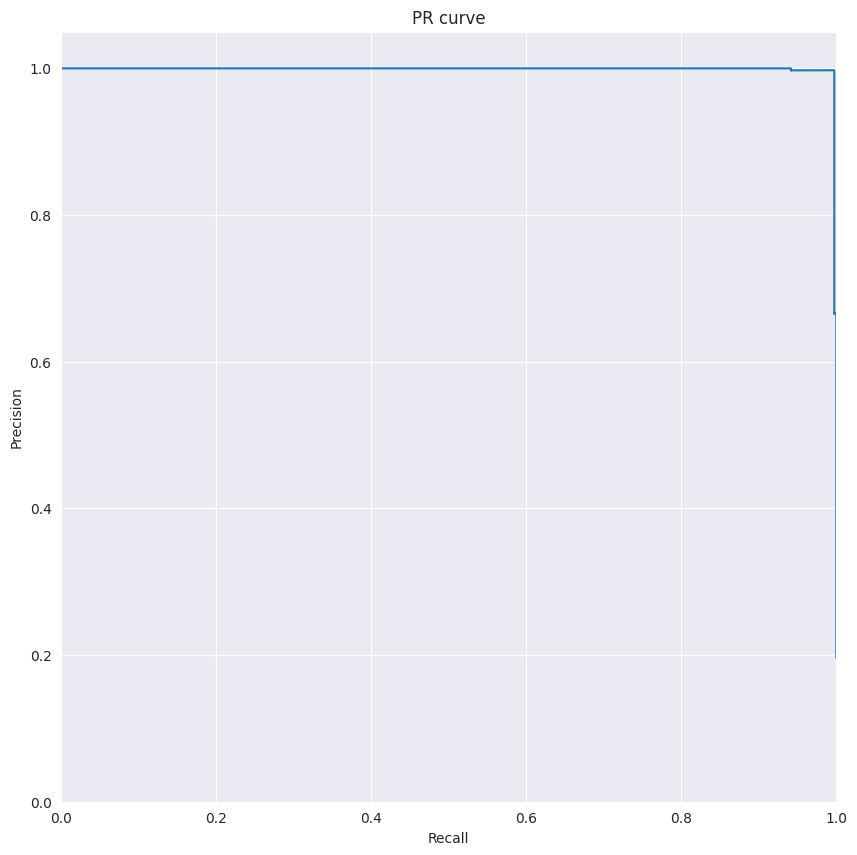

In [274]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show()

Le modèle est très performant sur une large gamme de seuils, avec un équilibre remarquable entre précision et rappel, sauf à très faibles seuils où le compromis est moins bon. Cela suggère que le choix du seuil entre 0,05 et 0,80 est assez flexible pour garder de très bonnes performances.

#### Random forest

Threshold = 0.00 | Precision = 0.831, Recall = 0.997 | F1-score = 0.906
Threshold = 0.05 | Precision = 0.831, Recall = 0.997 | F1-score = 0.906
Threshold = 0.10 | Precision = 0.992, Recall = 0.997 | F1-score = 0.995
Threshold = 0.15 | Precision = 0.992, Recall = 0.997 | F1-score = 0.995
Threshold = 0.20 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.25 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.30 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.35 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.40 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.45 | Precision = 0.997, Recall = 0.997 | F1-score = 0.997
Threshold = 0.50 | Precision = 0.997, Recall = 0.995 | F1-score = 0.996
Threshold = 0.55 | Precision = 0.997, Recall = 0.995 | F1-score = 0.996
Threshold = 0.60 | Precision = 0.997, Recall = 0.995 | F1-score = 0.996
Threshold = 0.65 | Precision = 0.997, Recall = 0.995 | F1-score 

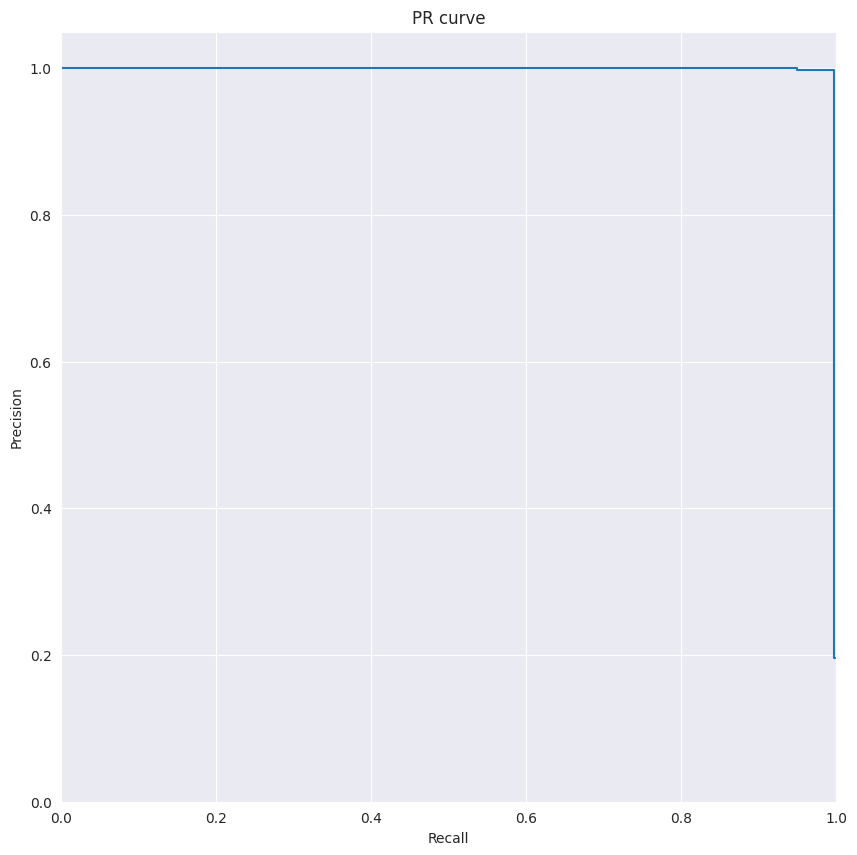

In [275]:
model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show()

Après analyse des résultats, on constate que le meilleur compromis entre précision et rappel se situe principalement dans la plage de seuils comprise entre 0,60 et 0,80. Dans cette zone, la précision reste très élevée (environ 0,997) tout comme le rappel (également autour de 0,997), ce qui permet d’atteindre un F1-score optimal. Ce choix de seuil est crucial, car il garantit à la fois une faible proportion de faux positifs (grâce à la précision élevée) et une bonne détection des vrais positifs (via le rappel élevé). En pratique, ajuster le seuil dans cette fourchette permet d’optimiser la performance globale du modèle, en s’adaptant aux exigences spécifiques du problème, notamment lorsque l’équilibre entre faux positifs et faux négatifs est déterminant.

Nous avons opté pour une stratégie de suréchantillonnage consistant à augmenter la taille de l’échantillon d’apprentissage. Les modèles seront entraînés sur cet échantillon enrichi, et les hyperparamètres y seront sélectionnés. Aucun ajustement du seuil de décision ne sera effectué, et l’échantillon ne sera pas réduit

### Entraînement des modèles et ajustement des hyperparamètres

**« Le modèle sera entraîné sur un échantillon élargi. Les hyperparamètres seront vérifiés à l’aide d’un échantillon de validation, et l’évaluation finale sera effectuée à l’aide de la mesure F1. Nous ne recourrons pas à la validation croisée pour la régression logistique et la forêt aléatoire.**

**La sélection des hyperparamètres sera effectuée à l’aide de `GridSearchCV`. Ni les boucles explicites ni l’énumération manuelle ne seront utilisées. »**

#### Logistic regression

In [276]:
par_grid_logist = {
                   'intercept_scaling': [0.5, 1.0, 1.5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.5, 1, 1.5]
                   }
model = LogisticRegression(solver='liblinear',random_state=42)

grid_search = GridSearchCV(model, par_grid_logist, cv=5,
                           scoring='f1')
grid_search.fit(features_upsampled, target_upsampled)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': [0.5, 1, 1.5], 'class_weight': [None, 'balanced'],
                         'intercept_scaling': [0.5, 1.0, 1.5]},
             scoring='f1')

In [277]:
grid_search.best_params_

{'C': 0.5, 'class_weight': None, 'intercept_scaling': 0.5}

Appliquons nos paramètres et observons le résultat

In [278]:
model_lreg = LogisticRegression(C=0.5, class_weight=None, intercept_scaling=0.5,
                                solver='liblinear', random_state=42
)
model_lreg.fit(features_upsampled, target_upsampled)
predicted_valid = model_lreg.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))


F1: 0.9974554707379135


**« En dessous du seuil de 0,60, voyons comment le modèle se comportera lors des tests. »**


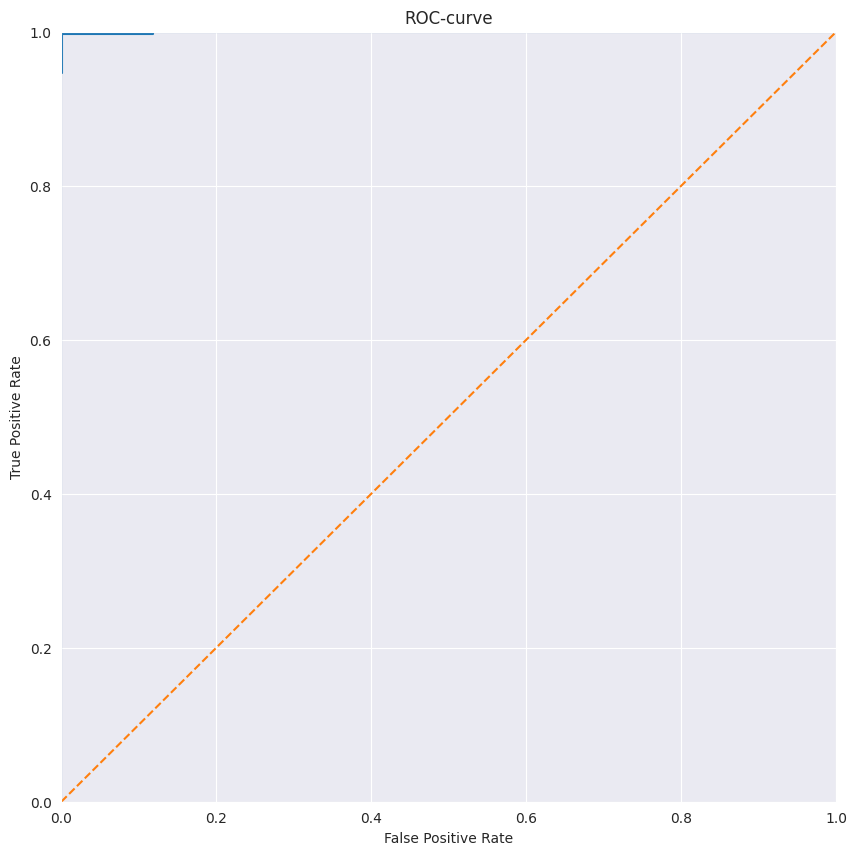

AUC: 0.999665901882825


In [279]:
probabilities_valid = model_lreg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

**« Avec une AUC supérieure à 0,5, notre modèle est meilleur qu’un modèle aléatoire. »**

L’interprétation est la suivante :

* Une AUC de 0,5 correspond à un modèle qui prédit au hasard.
* Plus l’AUC est proche de 1, meilleure est la capacité du modèle à distinguer les classes positives et négatives.
**Conclusion* : Notre modèle distingue parfaitement les classes positives et négatives

#### Random forest

In [280]:
par_grid_ensemble = {'n_estimators': [3, 10, 30],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5,
                           scoring='accuracy'
                          )
grid_search.fit(features_upsampled, target_upsampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': range(5, 15),
                         'n_estimators': [3, 10, 30]},
             scoring='accuracy')

In [281]:
grid_search.best_params_

{'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 10}

In [282]:
model_rfc = RandomForestClassifier(random_state=42, criterion='gini',
                               min_samples_split=5, n_estimators=10
                              )
model_rfc.fit(features_upsampled, target_upsampled)
predicted_valid = model_rfc.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.9974554707379135


 Au-dessus du seuil de 0,60 sur le jeu de validation. Essayons maintenant sur un échantillon de test pour voir comment le modèle se comporte sur des données non familières.

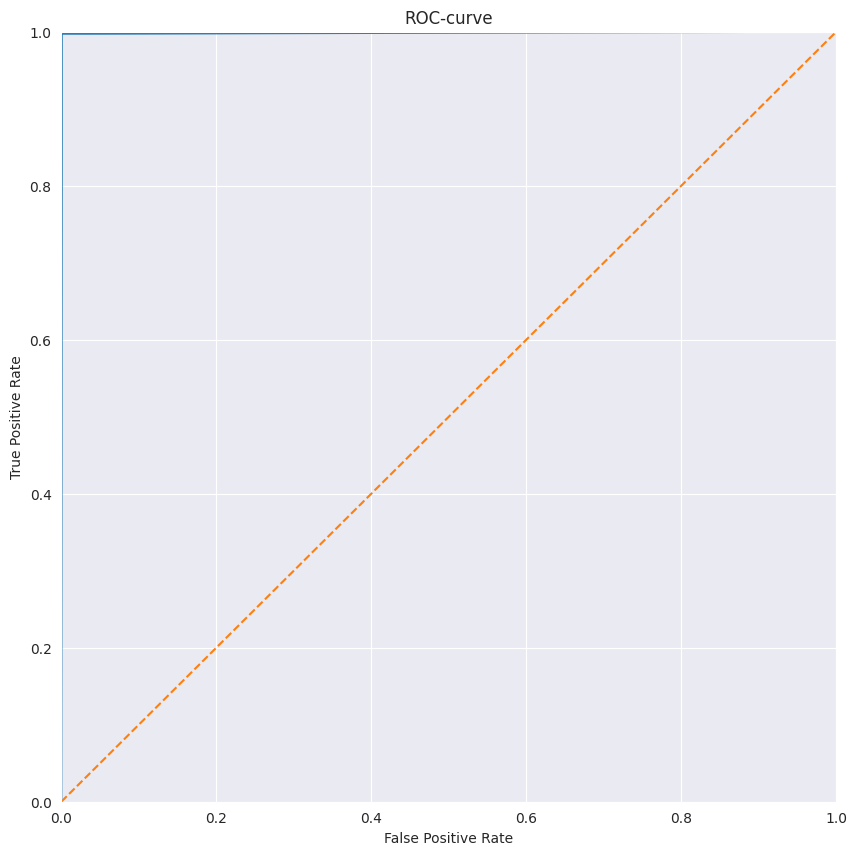

AUC: 0.9983295094141249


In [283]:
probabilities_valid = model_rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

L’analyse des résultats montre que le modèle évalué présente une bonne capacité de discrimination, comme en témoigne une AUC supérieure à 0,5, ce qui indique qu’il est meilleur qu’un modèle aléatoire. En le testant sur un échantillon de données non vues, le modèle conserve des performances globalement satisfaisantes, traduisant une bonne généralisation. Toutefois, en comparaison directe avec la régression logistique, ses performances s’avèrent légèrement inférieures, notamment sur les métriques clés telles que le F1-score et l’AUC. Cela suggère que, dans ce cas précis, la régression logistique reste plus adaptée au jeu de données étudié.

#### Catboost (bonus)

 Essayons de configurer CatBoost en utilisant la validation croisée. Nous obtiendrons le modèle de base et l’évaluerons à l’aide du F1-score, sans tenir compte du déséquilibre des classes.

In [284]:
model_cat = CatBoostClassifier(
                           custom_loss=['F1'],
                           random_seed=42,
                           logging_level='Silent'
)

In [285]:
model_cat.fit(
          features_train, target_train,
          eval_set=(features_valid, target_valid)

)


**« Obtiens la grille de paramètres et effectue une validation croisée en utilisant la fonction Pool intégrée. »**


In [286]:
cv_params = model_cat.get_params()
cv_params.update({
                 'loss_function': 'Logloss'
})
cv_data = cv(
             Pool(features_train, target_train),
             cv_params
)

In [287]:
print('F1-score: {}'.format(np.max(cv_data['test-F1-mean'])))

F1-score: 0.9971658187716582


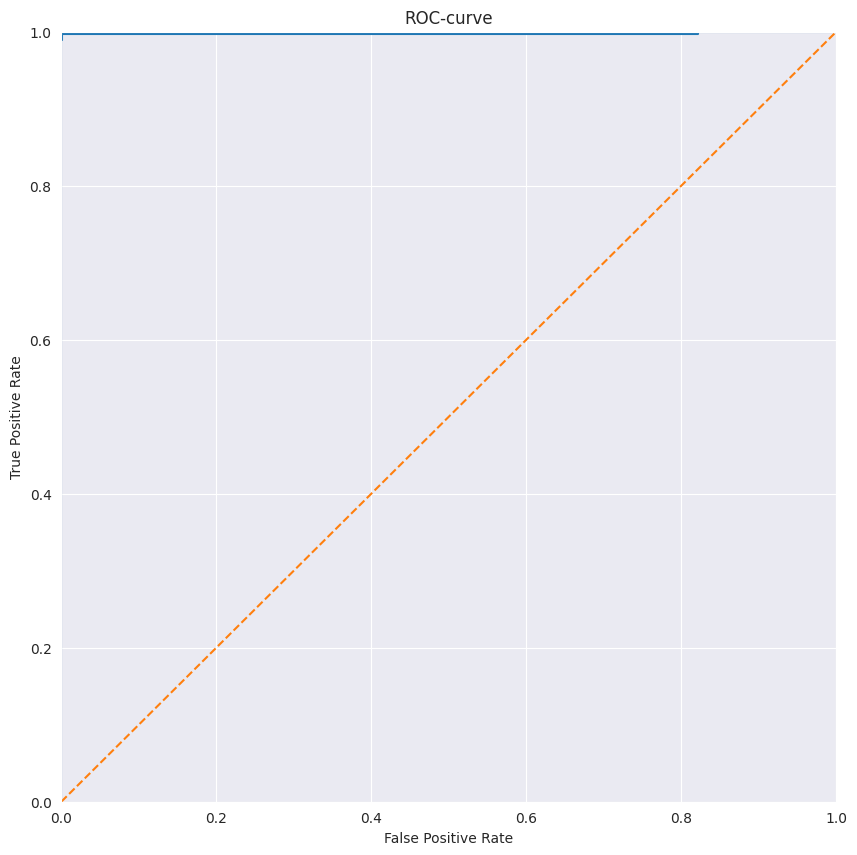

AUC: 0.9979051573032107


In [288]:
probabilities_valid = model_cat.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

 Nous avons obtenu un très bon résultat, voyons maintenant comment le modèle se comportera sur le jeu de test. Le modèle est meilleur que le hasard

## Model testing and validation

In [289]:
# collect indicators in lists

table_of_model = []
table_of_prec = []
table_of_acc = []

### Testing Models

#### Logistic regression

In [290]:
predictions_test = model_lreg.predict(features_test)
test_f1 = f1_score(target_test, predictions_test)
test_acc = accuracy_score(target_test, predictions_test)

print("Accuracy")
print("Test set:", test_acc)
print("F1-мера")
print("Test set:", test_f1)

table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('LogisticRegression')

Accuracy
Test set: 0.9975
F1-мера
Test set: 0.9939540507859734


#### Random forest

In [291]:
predictions_test = model_rfc.predict(features_test)
test_f1 = f1_score(target_test, predictions_test)
test_acc = accuracy_score(target_test, predictions_test)

print("Accuracy")
print("Test set:", test_acc)
print("F1-мера")
print("Test set:", test_f1)

table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('RandomForestClassifier')

Accuracy
Test set: 0.9975
F1-мера
Test set: 0.9939540507859734


In [292]:
model_rfc.feature_importances_

array([1.61271562e-03, 3.55500485e-02, 1.36988867e-03, 8.09814559e-03,
       2.83218222e-02, 2.12164060e-04, 1.06830791e-02, 3.15430961e-03,
       8.89615880e-01, 6.15484966e-04, 2.97318780e-03, 2.46531837e-03,
       1.27255886e-02, 8.53218131e-04, 3.93362773e-04, 6.23665355e-04,
       7.32120690e-04])

In [293]:
features_test.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'complain', 'satisfaction score',
       'point earned', 'Male', 'Germany', 'Spain', 'GOLD', 'PLATINUM',
       'SILVER'],
      dtype='object')

In [294]:
fi = pd.DataFrame({'name':features_test.columns,'fi':model_rfc.feature_importances_})
fi.sort_values('fi',ascending=False)

,name,fi
8,complain,0.889616
1,age,0.035550
4,numofproducts,0.028322
12,Germany,0.012726
6,isactivemember,0.010683
3,balance,0.008098
7,estimatedsalary,0.003154
10,point earned,0.002973
11,Male,0.002465
0,creditscore,0.001613


#### Catboost

In [295]:
predictions = model_cat.predict(features_test)
test_f1 = f1_score(target_test, predictions_test)
test_acc = accuracy_score(target_test, predictions_test)

print("Accuracy")
print("Test set:", test_acc)
print("F1-мера")
print("Test set:", test_f1)

table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('Catboost')

Accuracy
Test set: 0.9975
F1-мера
Test set: 0.9939540507859734


In [296]:
model_cat.feature_importances_

array([8.02509087e-01, 1.98064571e+00, 9.13693557e-01, 1.08881535e+00,
       1.17427514e+00, 1.92708675e-01, 4.98823558e-02, 1.24168297e+00,
       8.87152368e+01, 1.01176252e+00, 1.19033605e+00, 1.29884529e-01,
       3.86340595e-01, 1.89005963e-01, 2.59876360e-01, 1.56990737e-01,
       5.16353588e-01])

In [297]:
fi_cat = pd.DataFrame({'name':features_test.columns,'fi_cat':model_cat.feature_importances_})
fi_cat.sort_values('fi_cat',ascending=False)

,name,fi_cat
8,complain,88.715237
1,age,1.980646
7,estimatedsalary,1.241683
10,point earned,1.190336
4,numofproducts,1.174275
3,balance,1.088815
9,satisfaction score,1.011763
2,tenure,0.913694
0,creditscore,0.802509
16,SILVER,0.516354


#### Conclusion

**Pour plus de commodité, nous afficherons un tableau de nos paramètres par modèle :**

In [298]:
table_of_models = (pd.DataFrame({'Model':table_of_model, 'Accuracy':table_of_acc,
                                'F1 score':table_of_prec}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_of_models['Threshold of testing'] = (
                   table_of_models['F1 score'].apply(lambda x: 'bon modèle' if x>0.59 else 'mauvais modèle')
)
table_of_models

,Model,Accuracy,F1 score,Threshold of testing
0,LogisticRegression,1.0,0.99,bon modèle
1,RandomForestClassifier,1.0,0.99,bon modèle
2,Catboost,1.0,0.99,bon modèle




**« Les trois modèles présentent d’excellentes performances.

Nous avons également analysé les caractéristiques les plus importantes pour ces modèles de classification : la variable “plainte” arrive en tête avec un F1-score très élevé, suivie par l’âge, le nombre de produits détenus, et l’activité du compte. »**


### Senity test

#### Comparison with constant

Comparons nos modèles à un modèle constant : il prédit la classe "0" pour chaque observation.

In [299]:
target_const = target*0
acc_const = accuracy_score(target, target_const)


print("Accuracy")
print("const:", acc_const)


Accuracy
const: 0.7962


Les trois modèles ont été validés. La précision de nos modèles est supérieure à celle d’un modèle aléatoire. Nous avons également examiné les validations ROC-AUC, où nos modèles ont montré de meilleures performances.

## Conclusion

Nous avons disposé de données historiques sur le comportement des clients et la résiliation des contrats avec la banque. À partir de ces données, nous avons construit des caractéristiques pour entraîner le modèle afin de prédire l’attrition des clients. Nous avons obtenu de très bons résultats avec les trois modèles, mais nous retiendrons principalement la Random Forest, avec une mesure F1 de 0,99.

In [300]:
fi.sort_values('fi',ascending=False).reset_index(drop=True).head()

,name,fi
0,complain,0.889616
1,age,0.035550
2,numofproducts,0.028322
3,Germany,0.012726
4,isactivemember,0.010683


« Les signes les plus importants à surveiller sont :

la plainte du client (importance : 0,89)

l’âge (importance : 0,036)

le nombre de produits détenus (importance : 0,028)

la nationalité allemande (importance : 0,013)

l’activité du compte (importance : 0,011)

Ces indicateurs ont été identifiés comme les plus influents dans le modèle. »**


Pour prédire l’attrition, nous allons utiliser un modèle basé sur l’algorithme Random Forest.

**Sauvegarde du modèle**

In [301]:
joblib.dump(model_rfc, 'random_forest_model.pkl')
print("Modèle sauvegardé dans random_forest_model.pkl")

Modèle sauvegardé dans random_forest_model.pkl
